
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

#LR = 1e-3          # The initial Learning Rate
LR = 1e-2            

MOMENTUM = 0.9       # Hyperparameter for SGD, kept this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, kept this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

EVAL_MODEL_AFTER_EACH_EPOCH = True
EVAL_ACCURACY_ON_TRAINING = True

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

**Caltech Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

In [5]:
DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
limit = len(train_dataset)

#Split train into train and validation
train_indexes, val_indexes = train_test_split([i for i in range(len(train_dataset))], \
                                                              test_size=0.5, \
                                                              stratify=[item[1] for item in train_dataset.data])

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

opening: Caltech101/train.txt
opening: Caltech101/test.txt
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Prepare Network**

In [7]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
criterion_val = nn.CrossEntropyLoss(reduction='sum')

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet


# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [9]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
losses_train = []
losses_val = []
accuracies_val = []
accuracies_train = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    if current_step == 0:
      print('--- Initial loss on train: {}'.format(loss.item()))

    # Log loss
    #if current_step % LOG_FREQUENCY == 0:
    #  print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  #End of one epoch
  print('--- Epoch {}, Loss on train: {}'.format(epoch+1, loss.item()))
  losses_train.append(loss.item())  #add loss to a list to print it later

  if EVAL_MODEL_AFTER_EACH_EPOCH:
    #evaluate temporary model on validation set (after each epoch has finished)
    net.train(False)

    running_corrects_val = 0
    cum_loss_val = 0

    for images_val, labels_val in tqdm(val_dataloader):
      images_val = images_val.to(DEVICE)
      labels_val = labels_val.to(DEVICE)

      # Forward Pass
      outputs_val = net(images_val)
      cum_loss_val += criterion_val(outputs_val, labels_val).item()

      # Get predictions
      _, preds = torch.max(outputs_val.data, 1)

      # Update Corrects
      running_corrects_val += torch.sum(preds == labels_val.data).data.item()
    
    #Calculate Accuracy
    accuracy_val = running_corrects_val / float(len(val_dataset))
    loss_val = cum_loss_val / float(len(val_dataset))

    losses_val.append(loss_val)
    accuracies_val.append(accuracy_val)
    
    print('\n')
    print('Loss on val:', loss_val)
    print('Accuracy on val:', accuracy_val)

  if EVAL_ACCURACY_ON_TRAINING:
    #evaluate temporary model on training set (accuracy only, loss has already been computed)
    net.train(False)

    running_corrects_train = 0

    for images_train, labels_train in tqdm(train_dataloader):
      images_train = images_train.to(DEVICE)
      labels_train = labels_train.to(DEVICE)

      # Forward Pass
      outputs_train = net(images_train)

      # Get predictions
      _, preds = torch.max(outputs_train.data, 1)

      # Update Corrects
      running_corrects_train += torch.sum(preds == labels_train.data).data.item()
    
    #Calculate Accuracy
    accuracy_train = running_corrects_train / float(len(train_dataset))

    accuracies_train.append(accuracy_train)
    
    print('\n')
    print('Accuracy on training:', accuracy_train)
      

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


--- Initial loss on train: 4.623233318328857
--- Epoch 1, Loss on train: 4.614835262298584


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]




Loss on val: 4.609558063259098
Accuracy on val: 0.09197786998616875


100%|██████████| 11/11 [00:07<00:00,  1.41it/s]



Accuracy on training: 0.08852005532503458
Starting epoch 2/30, LR = [0.01]


--- Epoch 2, Loss on train: 4.595788478851318


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]




Loss on val: 4.583790738223169
Accuracy on val: 0.09197786998616875


100%|██████████| 11/11 [00:08<00:00,  1.36it/s]




Accuracy on training: 0.08921161825726141
Starting epoch 3/30, LR = [0.01]
--- Epoch 3, Loss on train: 4.551727294921875


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]




Loss on val: 4.549164820838601
Accuracy on val: 0.09197786998616875


100%|██████████| 11/11 [00:07<00:00,  1.39it/s]




Accuracy on training: 0.09024896265560166
Starting epoch 4/30, LR = [0.01]
--- Epoch 4, Loss on train: 4.450794219970703


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]




Loss on val: 4.4323986364762975
Accuracy on val: 0.09197786998616875


100%|██████████| 11/11 [00:08<00:00,  1.29it/s]




Accuracy on training: 0.08921161825726141
Starting epoch 5/30, LR = [0.01]
--- Epoch 5, Loss on train: 4.281040191650391


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]




Loss on val: 4.278713622033844
Accuracy on val: 0.09232365145228216


100%|██████████| 11/11 [00:07<00:00,  1.41it/s]




Accuracy on training: 0.08782849239280774
Starting epoch 6/30, LR = [0.01]
--- Epoch 6, Loss on train: 4.165213584899902


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]




Loss on val: 4.203872912817147
Accuracy on val: 0.09197786998616875


100%|██████████| 11/11 [00:07<00:00,  1.38it/s]




Accuracy on training: 0.08990318118948824
Starting epoch 7/30, LR = [0.01]
--- Epoch 7, Loss on train: 4.102677345275879


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]




Loss on val: 4.170352276265209
Accuracy on val: 0.1165283540802213


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]



Accuracy on training: 0.11203319502074689
Starting epoch 8/30, LR = [0.01]


--- Epoch 8, Loss on train: 4.11587381362915


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 4.139824873843793
Accuracy on val: 0.13692946058091288


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.13658367911479943
Starting epoch 9/30, LR = [0.01]
--- Epoch 9, Loss on train: 3.97182559967041


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]




Loss on val: 4.093047768578325
Accuracy on val: 0.11272475795297372


100%|██████████| 11/11 [00:08<00:00,  1.35it/s]



Accuracy on training: 0.11168741355463348
Starting epoch 10/30, LR = [0.01]


--- Epoch 10, Loss on train: 4.1305694580078125


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]




Loss on val: 4.081582624717702
Accuracy on val: 0.16147994467496543


100%|██████████| 11/11 [00:08<00:00,  1.33it/s]




Accuracy on training: 0.16355463347164592
Starting epoch 11/30, LR = [0.01]
--- Epoch 11, Loss on train: 3.8754830360412598


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]




Loss on val: 3.9523516347629237
Accuracy on val: 0.18914246196403872


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.18914246196403872
Starting epoch 12/30, LR = [0.01]
--- Epoch 12, Loss on train: 3.730949640274048


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]




Loss on val: 3.905786981226498
Accuracy on val: 0.1912171507607192


100%|██████████| 11/11 [00:07<00:00,  1.41it/s]



Accuracy on training: 0.18741355463347165
Starting epoch 13/30, LR = [0.01]


--- Epoch 13, Loss on train: 3.854094982147217


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]




Loss on val: 3.819546194327158
Accuracy on val: 0.21334716459197786


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]



Accuracy on training: 0.20262793914246197
Starting epoch 14/30, LR = [0.01]


--- Epoch 14, Loss on train: 3.7930333614349365


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]




Loss on val: 3.7174070788287192
Accuracy on val: 0.20608575380359612


100%|██████████| 11/11 [00:08<00:00,  1.32it/s]



Accuracy on training: 0.20643153526970953
Starting epoch 15/30, LR = [0.01]


--- Epoch 15, Loss on train: 3.704765796661377


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 3.632599932194416
Accuracy on val: 0.21473029045643152


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]




Accuracy on training: 0.21265560165975103
Starting epoch 16/30, LR = [0.01]
--- Epoch 16, Loss on train: 3.5351972579956055


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]




Loss on val: 3.559104455127426
Accuracy on val: 0.23409405255878285


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.23098201936376211
Starting epoch 17/30, LR = [0.01]
--- Epoch 17, Loss on train: 3.4265291690826416


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]




Loss on val: 3.506621406945615
Accuracy on val: 0.25553250345781464


100%|██████████| 11/11 [00:07<00:00,  1.38it/s]



Accuracy on training: 0.24308437067773167
Starting epoch 18/30, LR = [0.01]


--- Epoch 18, Loss on train: 3.1642017364501953


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]




Loss on val: 3.4799765643572247
Accuracy on val: 0.2621023513139696


100%|██████████| 11/11 [00:08<00:00,  1.33it/s]




Accuracy on training: 0.2551867219917012
Starting epoch 19/30, LR = [0.01]
--- Epoch 19, Loss on train: 3.240365982055664


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 3.467086369895671
Accuracy on val: 0.26141078838174275


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.25864453665283543
Starting epoch 20/30, LR = [0.01]
--- Epoch 20, Loss on train: 3.489631175994873


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]




Loss on val: 3.3832998631900773
Accuracy on val: 0.2669432918395574


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.2690179806362379
Starting epoch 21/30, LR = [0.0001]
--- Epoch 21, Loss on train: 3.369359254837036


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]




Loss on val: 3.319398070107192
Accuracy on val: 0.2714384508990318


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.2721300138312586
Starting epoch 22/30, LR = [0.001]
--- Epoch 22, Loss on train: 3.2274885177612305


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]




Loss on val: 3.2612737230905027
Accuracy on val: 0.28561549100968187


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]




Accuracy on training: 0.2863070539419087
Starting epoch 23/30, LR = [0.001]
--- Epoch 23, Loss on train: 3.225062608718872


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]




Loss on val: 3.247108343396114
Accuracy on val: 0.2859612724757953


100%|██████████| 11/11 [00:08<00:00,  1.36it/s]




Accuracy on training: 0.2859612724757953
Starting epoch 24/30, LR = [0.001]
--- Epoch 24, Loss on train: 3.068434953689575


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 3.236969716980909
Accuracy on val: 0.28803596127247577


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.2939142461964039
Starting epoch 25/30, LR = [0.001]
--- Epoch 25, Loss on train: 3.2561404705047607


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 3.2256162862395183
Accuracy on val: 0.29322268326417705


100%|██████████| 11/11 [00:08<00:00,  1.35it/s]




Accuracy on training: 0.29806362378976486
Starting epoch 26/30, LR = [0.001]
--- Epoch 26, Loss on train: 3.1959285736083984


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 3.225954074252855
Accuracy on val: 0.29356846473029047


100%|██████████| 11/11 [00:08<00:00,  1.36it/s]



Accuracy on training: 0.2991009681881051
Starting epoch 27/30, LR = [0.001]


--- Epoch 27, Loss on train: 3.0078041553497314


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]




Loss on val: 3.1887688748899174
Accuracy on val: 0.30013831258644535


100%|██████████| 11/11 [00:08<00:00,  1.37it/s]




Accuracy on training: 0.30567081604426005
Starting epoch 28/30, LR = [0.001]
--- Epoch 28, Loss on train: 3.130511999130249


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]




Loss on val: 3.1742172768831582
Accuracy on val: 0.30255878284923926


100%|██████████| 11/11 [00:08<00:00,  1.31it/s]




Accuracy on training: 0.31051175656984786
Starting epoch 29/30, LR = [0.001]
--- Epoch 29, Loss on train: 2.8984057903289795


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]




Loss on val: 3.1640114738073915
Accuracy on val: 0.30567081604426005


100%|██████████| 11/11 [00:08<00:00,  1.28it/s]




Accuracy on training: 0.3118948824343015
Starting epoch 30/30, LR = [0.001]
--- Epoch 30, Loss on train: 3.086517810821533


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]




Loss on val: 3.1506693089486486
Accuracy on val: 0.31224066390041494


100%|██████████| 11/11 [00:07<00:00,  1.39it/s]




Accuracy on training: 0.31984785615491007


**Plot Results After Training**

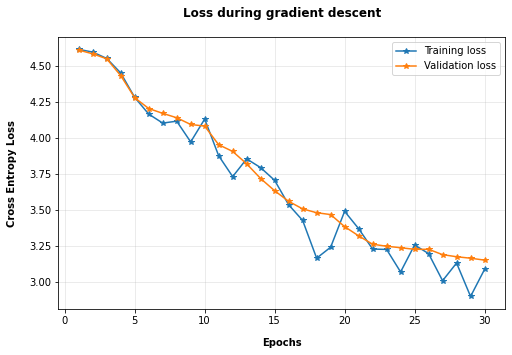

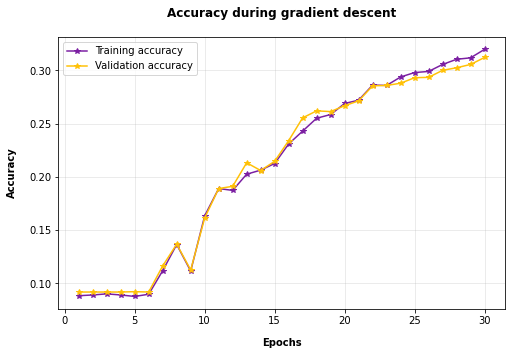

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax.plot(epochs, losses_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, losses_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot accuracies

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax.plot(epochs, accuracies_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, accuracies_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

**Validation**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

Validation Accuracy: 0.31224066390041494


**Test**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

Test Accuracy: 0.311787072243346
